# Circular cross-correlation

Circular cross-correlation between two signals is calculated in Fourier space using z-score normalized data.

---
Disclaimer:

This notebook is part of the paper:

Christoph Spahn, Stuart Middlemiss, Estibaliz Gómez-de-Mariscal, Ricardo Henriques, Helge B. Bode, Séamus Holden, Mike Heilemann , *Transertion and cell geometry organize the Escherichia coli nucleoid during rapid growth*, bioRxiv 2023 (https://doi.org/10.1101/2023.10.16.562172)

Please, cite it if you find it useful for your research.

## Data structure

You will need to add the path to a folder containing one `.txt`file for each object to analyse. The `.txt`file should have the following structure:

| Distance | Value 1 | Value 2 |
|:-:|:-:|:-:|
|0 | 17.7272 | 7.1331 |
|0.01 | 19.1092| 7.9044 |
|0.02 | 20.6539 | 9.6983 |

When opening the `.txt` file, it should look like this:

````
distance  Value 1	    Value 2
0         17.7272	    7.1331
0.01      19.1092	    7.9044
0.02      20.6539	    9.6983
````
Requirements:

```
matplotlib==3.5.1
numpy==1.21.2
pandas==1.3.5
scikit-learn==1.2.1
seaborn==0.12.2
```





In [1]:
#@markdown ##Load key dependencies

import os
import numpy as np
import pandas as pd
from numpy.fft import fft, ifft
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

def periodic_corr(x, y):
    return ifft(fft(x) * fft(y).conj()).real

def circular_xcorr(distance, array1, array2, step = 1):
    # Initialise the variables
    correlations = pd.DataFrame()
    correlations_rev = pd.DataFrame()

    # Reverse one of the arrays to obtain the reversed circular cross-correlation
    array2_rev = array2[::-1]
    cxcorr = periodic_corr(array1, array2) # Perform circular cross correlation
    cxcorr_rev = periodic_corr(array1, array2_rev) # Perform with one reverted array


    # Now we want to arrange the correlation from - 2 µm to +2 µm
    # TODO: the distance should be an input parameter. The function would need the resolution and desired length.
    neg_corr = cxcorr[-200:]
    pos_corr = cxcorr[0:201]

    neg_corr_rev = cxcorr_rev[-200:]
    pos_corr_rev = cxcorr_rev[0:201]

    # Realocate the values to center the crosscorrelation
    total_distance = int(len(cxcorr)/2)

    neg_corr = cxcorr[-total_distance:]
    pos_corr = cxcorr[0:total_distance+1]

    neg_corr_rev = cxcorr_rev[-total_distance:]
    pos_corr_rev = cxcorr_rev[0:total_distance+1]

    centered_corr = np.concatenate((neg_corr,pos_corr)) # Concatenates the two correlation parts
    centered_corr_rev = np.concatenate((neg_corr_rev,pos_corr_rev)) # Concatenates the two correlation parts

    # Distance for the plot. Get an array centered in 0 and scale it to the step size
    centered_distance = np.arange(-total_distance,total_distance + 1, 1)
    centered_distance = step*centered_distance
    #figure = sns.lineplot(x=centered_distance, y=centered_corr) # plots the circular cross correlation

    correlations['distance'] = centered_distance
    name = "cxcorr"
    correlations[name] = centered_corr

    correlations_rev['distance'] = centered_distance
    name = "cxcorr"
    correlations_rev[name] = centered_corr_rev

    return correlations, correlations_rev


def circular_xcross_folder(path2folder, step = None, limit = None):
    files = os.listdir(path2folder)
    print(f"Calculating the circular cross-correlation for the files in the folder: {os.path.basename(path2folder)}.")
    C = None
    C_REV = None
    for index, element in enumerate(files):
        if element.endswith(".txt"):
            df = pd.read_csv(os.path.join(path2folder, element), sep='\t')
            #Standardize the values by removing the mean and scaling to unit variance
            scaler = StandardScaler()
            df2 = scaler.fit_transform(df)
            array1 = df2[:,1]
            array2 = df2[:,2]
            distance = df.iloc[:,0]
            if step is None:
                step = distance[1] - distance[0]
                print(f"No step size is given. It is set by default to {step}.")
            correlations, correlations_rev = circular_xcorr(distance, array1, array2, step = step)
            correlations["ROI"] = index
            correlations_rev["ROI"] = index
            if C is None:
                C = correlations
                C_REV = correlations_rev
            else:
                C = pd.concat([C, correlations]).reset_index(drop=True)
                C_REV = pd.concat([C, correlations_rev]).reset_index(drop=True)
    if limit is not None:
        C = C[C["distance"]>limit[0]].reset_index(drop=True)
        C = C[C["distance"]<limit[1]].reset_index(drop=True)
        C_REV = C_REV[C_REV["distance"]>limit[0]].reset_index(drop=True)
        C_REV = C_REV[C_REV["distance"]<limit[1]].reset_index(drop=True)

    print(f"Calculations finished.")
    return C, C_REV

def plot_crosscorr(correlations, correlations_rev, limit = None, saving_path = None, name="circular_xcorr"):
    fig = plt.figure()
    figure = sns.lineplot(x='distance', y='cxcorr', data = correlations, color="black", errorbar=('se')) # plots the circular cross correlation
    figure = sns.lineplot(x='distance', y='cxcorr', data = correlations_rev, color="red",errorbar=('se'))
    figure.legend(["fw", "fw-se", "rv", "rv-se"])
    figure.set_ylabel("Circular cross-correlation")
    figure.set_xlabel("Distance in microns")
    if limit is not None:
        figure.set_xlim(limit)

    figure.set_title("fw: Forward, rv: Reversed, se: Standard error of the mean")
    if saving_path is not None:
        os.makedirs(saving_path, exist_ok=True)
        fig.savefig(os.path.join(saving_path, f"{name}.png"), format="png", transparent=False)


def analyse_folder_results(path2main, step = None, limit = None, saving_path = None):
    folders = os.listdir(path2main)
    C = None
    C_REV = None
    for f in folders:
        if not f.startswith("."): # avoid temporal files and similar
            print(f"Analysing data from folder: {f}")
            path2folder = os.path.join(path2main, f)

            correlations, correlations_rev = circular_xcross_folder(path2folder, step=step, limit=limit)

            if saving_path is not None:
                name = f"{f}_circular_xcorr"
                os.makedirs(saving_path, exist_ok=True)
            else:
                name = None

            plot_crosscorr(correlations, correlations_rev, saving_path = saving_path, name = name)

            # Update the info about the folder to store everything in one single dataframe
            correlations["folder"] = f
            correlations_rev["folder"] = f

            if C is None:
                C = correlations
                C_REV = correlations_rev
            else:
                C = pd.concat([C, correlations]).reset_index(drop=True)
                C_REV = pd.concat([C, correlations_rev]).reset_index(drop=True)

    return C, C_REV

In [2]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Plot the circular cross correlation for one single group of elements

Calculating the circular cross-correlation for the files in the folder: 0_min.
Calculations finished.
Extracting the analytical data for the plot...


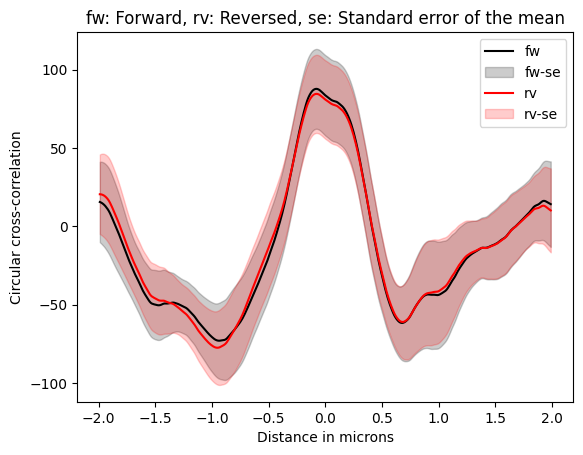

In [4]:
# ------------- Initial user input ------------
#@markdown ###Intorduce the path to the folder containing the measurements:
path2example = "/content/gdrive/MyDrive/HENRIQUES LAB/PROJECTS/NUCLEOID/2017-01-18 NO34_LB5_32C_100ug_ml_rif/0_min" #@param {type:"string"}

#@markdown ###Indicate what is the distance between each measurement:
Is_the_step_size_known = True #@param {type:"boolean"}
step_size = 0.01 #@param {type:"number"}
if not Is_the_step_size_known:
    step_size = None

#@markdown ###Indicate whether you want to limit the window to visualise the results.
#@markdown ####Give a number following the same units as the previous step size:
Limit_distance_range = True #@param {type:"boolean"}
distance_limit = 2 #@param {type:"number"}
if not Limit_distance_range:
    limit = None
else:
    limit = [-distance_limit, distance_limit]
#@markdown ###Choose a path to save the plot. Otherwise, write `None`
Saving_path = "None" #@param {type:"string"}
correlations, correlations_rev = circular_xcross_folder(path2example, step=step_size, limit=limit)
print("Extracting the analytical data for the plot...")
if Saving_path == "None":
    Saving_path = None
    name = None
else:
    name = os.path.basename(path2example)
plot_crosscorr(correlations, correlations_rev, saving_path = Saving_path, name = name)

## Plot the circular cross correlation for different groups. This cell will identify the folders in the directory adn analyse one by one each of them. The expected structure is as follows:
````
Main folder
 |-- Folder - group 1
     |-- Text file Object 1
     |-- Text file Object 2
     |-- Text file Object 3
 |-- Folder - group 2
     |-- Text file Object 1
     |-- Text file Object 2
     |-- Text file Object 3
 |-- Folder - group 3
     |-- Text file Object 1
     |-- Text file Object 2
     |-- Text file Object 3
````

Processing the folder 2017-01-18 NO34_LB5_32C_100ug_ml_rif
Analysing data from folder: 60_min
Calculating the circular cross-correlation for the files in the folder: 60_min.
No step size is given. It is set by default to 0.01.
Calculations finished.
Analysing data from folder: 30_min
Calculating the circular cross-correlation for the files in the folder: 30_min.
No step size is given. It is set by default to 0.01.
Calculations finished.
Analysing data from folder: 0_min
Calculating the circular cross-correlation for the files in the folder: 0_min.
No step size is given. It is set by default to 0.01.
Calculations finished.


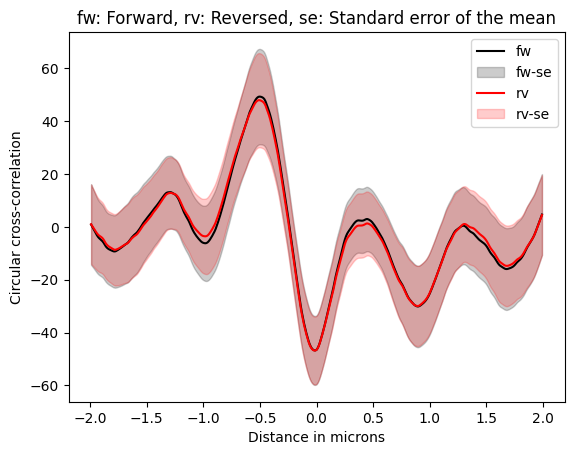

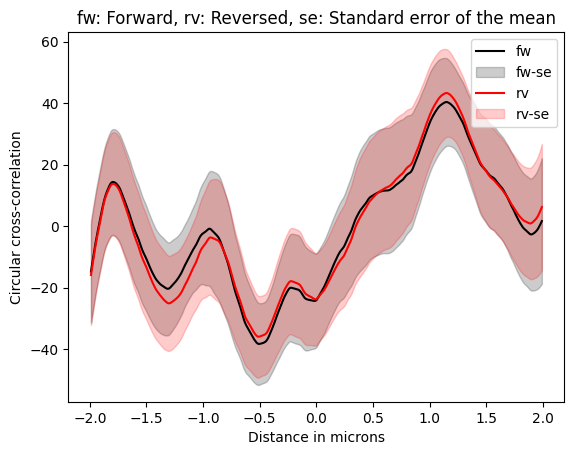

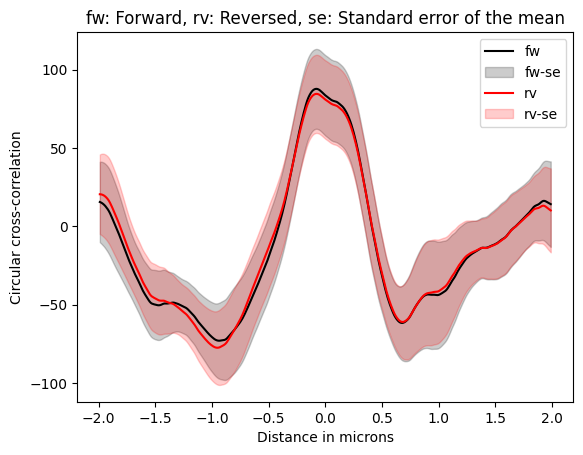

In [5]:
# ------------- Initial user input ------------
#@markdown ###Intorduce the path to the folder containing the measurements:
path2main = "/content/gdrive/MyDrive/HENRIQUES LAB/PROJECTS/NUCLEOID/2017-01-18 NO34_LB5_32C_100ug_ml_rif" #@param {type:"string"}

#@markdown ###Indicate what is the distance between each measurement:
Is_the_step_size_known = False #@param {type:"boolean"}
step_size = 0.01 #@param {type:"number"}
if not Is_the_step_size_known:
    step_size = None

#@markdown ###Indicate whether you want to limit the window to visualise the results.
#@markdown ####Give a number following the same units as the previous step size:
Limit_distance_range = True #@param {type:"boolean"}
distance_limit = 2 #@param {type:"number"}
if not Limit_distance_range:
    limit = None
else:
    limit = [-distance_limit, distance_limit]
#@markdown ###Choose a path to save the plot. Otherwise, write `None`
Saving_path = "/content/gdrive/MyDrive/HENRIQUES LAB/PROJECTS/NUCLEOID/2017-01-18 NO34_LB5_32C_100ug_ml_rif" #@param {type:"string"}
if Saving_path == "None":
    Saving_path = None
print(f"Processing the folder {os.path.basename(path2main)}")
correlations, correlations_rev = analyse_folder_results(path2main, step = step_size, limit = limit, saving_path = Saving_path)

